In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report

from src.visualization import feature_importances_plot

# warnings -> to silence warnings
import warnings
warnings.filterwarnings("ignore")

In [15]:
RANDOM_STATE = 42
N_JOBS = -1

In [16]:
df = pd.read_csv("data/Dati_Matemaldomics.csv", delimiter=';', index_col='ID Strain')
df

,Year,Region,Animal species of origin,Organ of origin,ST,Species,Putative Subspecies,LANCEFIELD GROUP,Haemolysis,"2021,944237",...,scpA,sda,ska,slo,smeZ,spec,speg,spek,spel,spem
ID Strain,,,,,,,,,,,,,,,,,,,,,
V13,ante 2004,NaN,Dog,Urine,ST13,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V142,2008,NaN,Dog,Urine,ST23,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V151,2008,NaN,Dog,Ear,ST95,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V160,2011,NaN,Dog,Skin,ST15,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V161,2011,NaN,Cat,Lung,ST9,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,2021,NaN,Bovine,Milk,ST307,Streptococcus_dysgalactiae,Streptococcus dysgalactiae subsp. dysgalactiae,C,a,"5,57269E-05",...,0,1,0,0,0,0,0,0,0,0
V82,2006,NaN,Cat,Intestine,ST9,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V90,2006,NaN,Dog,Pus,ST13,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0


In [19]:
st = df[['ST']]
st.value_counts()

ST   
ST9      20
ST454     8
ST460     8
ST306     6
ST305     6
         ..
ST649     1
ST687     1
ST688     1
ST689     1
ST97      1
Length: 67, dtype: int64

In [4]:
metadati = df[['Year','Region','Animal species of origin','Organ of origin']]
metadati

,Year,Region,Animal species of origin,Organ of origin
ID Strain,,,,
V13,ante 2004,NaN,Dog,Urine
V142,2008,NaN,Dog,Urine
V151,2008,NaN,Dog,Ear
V160,2011,NaN,Dog,Skin
V161,2011,NaN,Cat,Lung
...,...,...,...,...
V800,2021,NaN,Bovine,Milk
V82,2006,NaN,Cat,Intestine
V90,2006,NaN,Dog,Pus


In [5]:
#Dato che non si può convertire ante 2004 in intero lo sostituisco con 2003 anche se non considera solo il 2003 ma tutti gli anni prima
metadati = metadati.replace('ante 2004','2003')
metadati['Year']=pd.to_numeric(metadati['Year'])

In [6]:
#sostituisce valori nulli sull'organo di origine con quello più frequente
organ_origin = metadati[["Organ of origin"]].values
si = SimpleImputer(strategy="most_frequent")
organ_origin_imputed = si.fit_transform(organ_origin)

In [7]:
metadati.drop(columns='Region', inplace=True)

In [8]:
#One-Hot encode delle variabili categoriche
metadati_X = ['Animal species of origin','Organ of origin']

ct_meta = ColumnTransformer(transformers=[
    ("OneHot", OneHotEncoder(drop="if_binary", sparse=False, dtype=int), metadati_X)
],remainder='passthrough')
#,remainder="passthrough"
metadati_arr = ct_meta.fit_transform(X=metadati)

In [9]:
map_target = {
    "Streptococcus canis" : "canis",
    "Streptococcus dysgalactiae subsp. equisimilis" : "equisimilis",
    "Streptococcus dysgalactiae subsp. dysgalactiae" : "dysgalactiae"  
}

X = pd.DataFrame(data=metadati_arr, columns=ct_meta.get_feature_names_out())
y = df['Putative Subspecies'].map(map_target)
X

,OneHot__Animal species of origin_Bovine,OneHot__Animal species of origin_Cat,OneHot__Animal species of origin_Dog,OneHot__Animal species of origin_Donkey,OneHot__Animal species of origin_Goat,OneHot__Animal species of origin_Hedgehog,OneHot__Animal species of origin_Horse,OneHot__Animal species of origin_Ovine,OneHot__Animal species of origin_Reference strain (CCUG),OneHot__Animal species of origin_Swine,...,OneHot__Organ of origin_Pus,OneHot__Organ of origin_Semen,OneHot__Organ of origin_Septicemia,OneHot__Organ of origin_Skin,OneHot__Organ of origin_Spleen,OneHot__Organ of origin_Tonsil,OneHot__Organ of origin_Urine,OneHot__Organ of origin_Vaginal swab,OneHot__Organ of origin_nan,remainder__Year
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2003
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2008
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2008
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2011
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2021
150,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2006
151,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2006
152,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2006


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [11]:
#Scaling dati
ss = MinMaxScaler()
X_train = ss.fit_transform(X=X_train)
X_test = ss.transform(X=X_test)

**Logistic Regression**

In [12]:
logr_md = LogisticRegression(random_state=RANDOM_STATE)
logr_md.fit(X=X_train,y=y_train)
logr_md

LogisticRegression(random_state=42)

In [13]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
logr_cv_scores = cross_val_score(estimator=logr_md, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV accuracy: {logr_cv_scores.mean():.4f} +/- {logr_cv_scores.std():.4f}")
logr_cv_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

Accuracy of logistic regression classifier on test set: 0.871


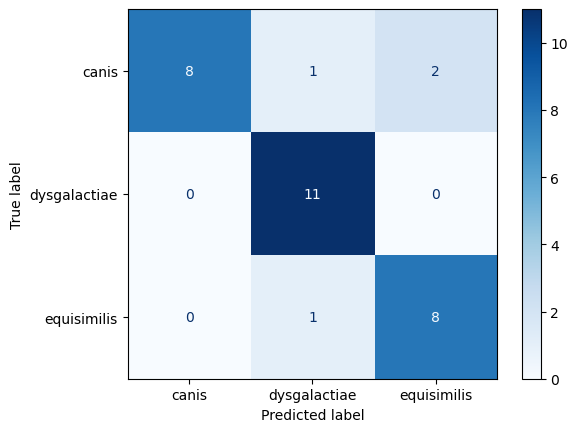

In [ ]:
y_pred = logr_md.predict(X_test)
accuracy_logic_md = logr_md.score(X_test, y_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(accuracy_logic_md))
ConfusionMatrixDisplay.from_estimator(estimator=logr_md, X=X_test, y=y_test, cmap='Blues')

In [ ]:
report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

       canis       1.00      0.73      0.84        11
dysgalactiae       0.85      1.00      0.92        11
 equisimilis       0.80      0.89      0.84         9

    accuracy                           0.87        31
   macro avg       0.88      0.87      0.87        31
weighted avg       0.89      0.87      0.87        31



**Decision Tree**

In [ ]:
dtc_md = DecisionTreeClassifier(random_state=RANDOM_STATE)
dtc_md = dtc_md.fit(X=X_train, y=y_train)
dtc_md

DecisionTreeClassifier(random_state=42)

In [ ]:
print(f"Profonfità albero: {dtc_md.get_depth()}")

Profonfità albero: 12


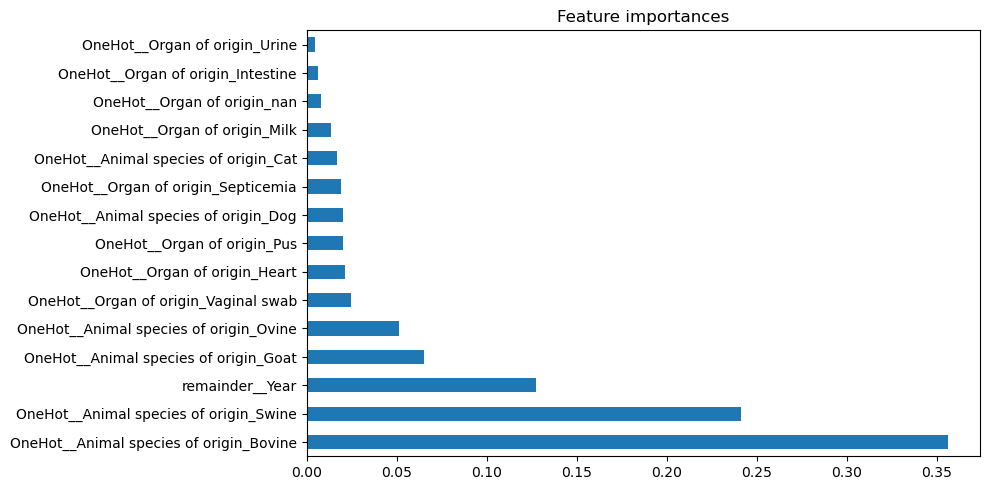

In [ ]:
#Dizionario con importanza feature
feature_importances = dtc_md.feature_importances_
feature_index = X.columns
myDict = dict(zip(feature_index, feature_importances))
myDict = dict(sorted(myDict.items(), key=lambda item: item[1], reverse = True))

#Plot delle 15 feature con più importanza
series = pd.Series(data=myDict.values(), index=myDict.keys()).head(15)
series.plot(kind="barh", figsize=(10, 5), title=f"Feature importances", legend=None)
plt.tight_layout()
plt.show()

In [ ]:
dtc_cv_scores = cross_val_score(estimator=dtc_md, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV accuracy: {dtc_cv_scores.mean():.4f} +/- {dtc_cv_scores.std():.4f}")
dtc_cv_scores

Mean CV accuracy: 0.8212 +/- 0.1081


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


array([0.92307692, 0.69230769, 0.84615385, 0.91666667, 1.        ,
       0.66666667, 0.75      , 0.75      , 0.91666667, 0.75      ])

Accuracy of decision tree classifier on test set: 0.871


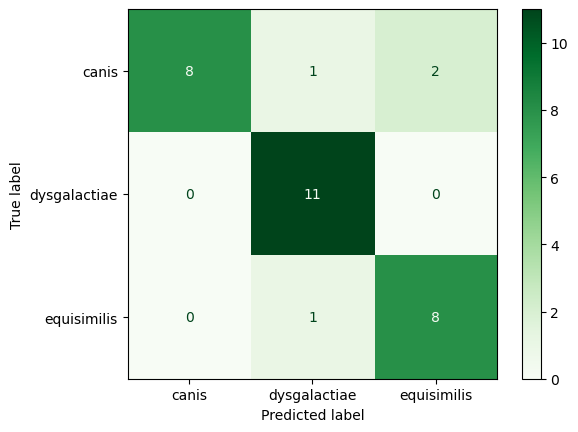

In [ ]:
y_pred = dtc_md.predict(X=X_test)
accuracy_albero_md = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of decision tree classifier on test set: {:.3f}'.format(accuracy_albero_md))
ConfusionMatrixDisplay.from_estimator(estimator=dtc_md, X=X_test, y=y_test, cmap='Greens')

In [ ]:
report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

       canis       1.00      0.73      0.84        11
dysgalactiae       0.85      1.00      0.92        11
 equisimilis       0.80      0.89      0.84         9

    accuracy                           0.87        31
   macro avg       0.88      0.87      0.87        31
weighted avg       0.89      0.87      0.87        31



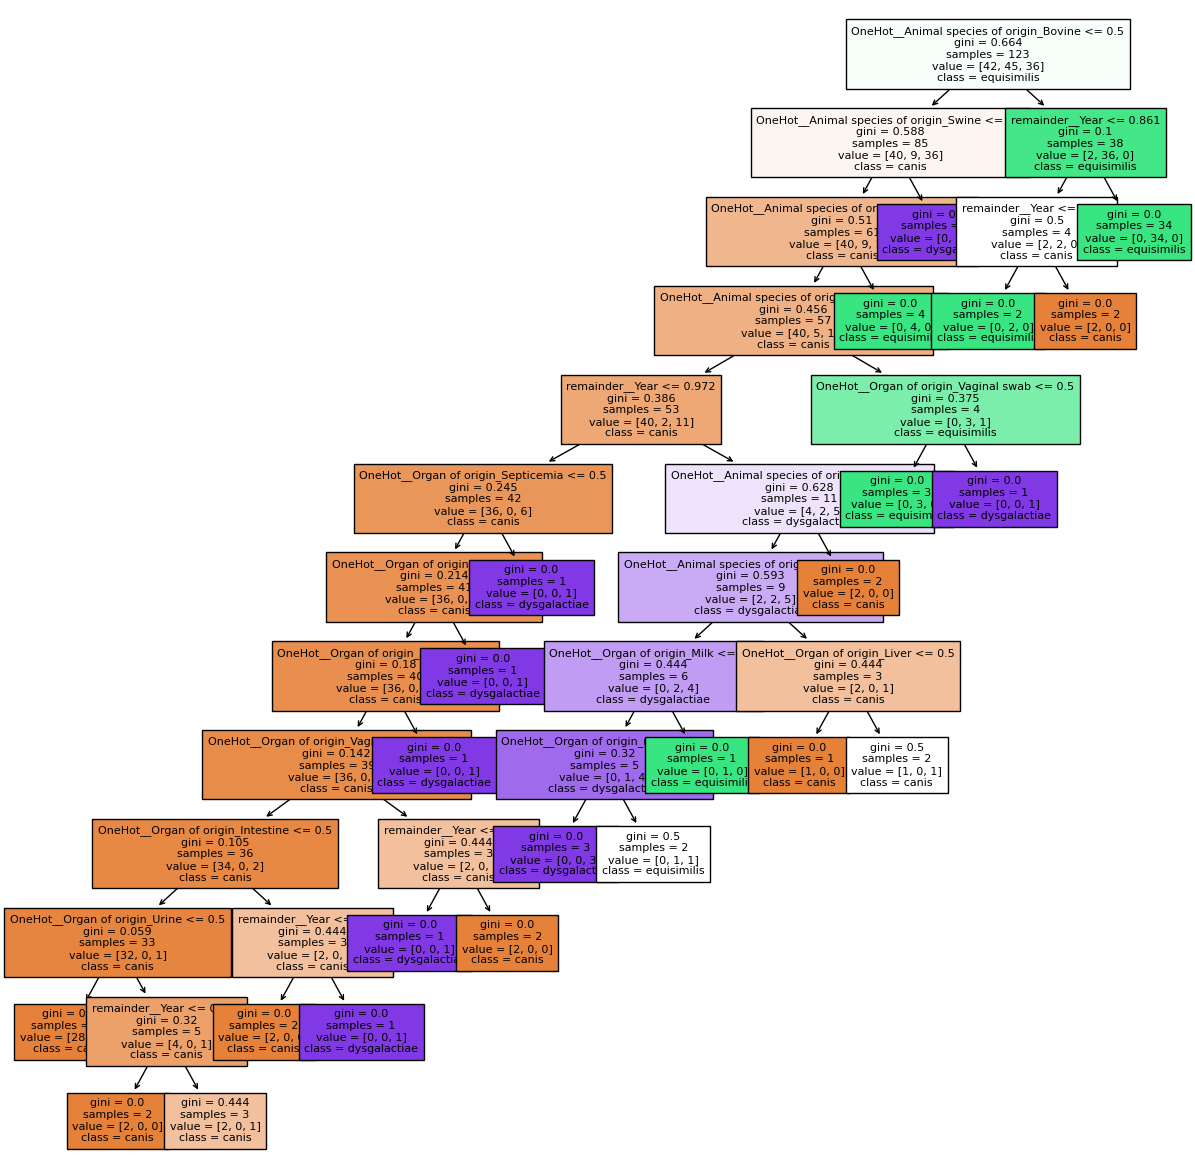

In [ ]:
feature_names = feature_index
class_names = ["Strept, canis","Strept. dysg. equisimilis", "Strept. dysg. dysgalactiae"]

plt.figure(figsize=(15, 15))
plot_tree(decision_tree=dtc_md, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, fontsize=8)
plt.show()

**Knn Classifier**

In [ ]:
knn_scores = []

for k in range(1, X_train.shape[0], 2):
    # model definition and training
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X=X_train, y=y_train)
    # compute accuracy on test set
    accuracy = knn.score(X_test, y_test)
    # store the results on a list of dictionaries
    metrics = {"# neighbors": k, "accuracy": accuracy}
    knn_scores.append(metrics)

# convert the list of dictionaries to pandas dataframe
df_knn_scores_md = pd.DataFrame(data=knn_scores)    #molto facile eveloce da dizionario a dataframe 
df_knn_scores_md

,# neighbors,accuracy
0,1,0.774194
1,3,0.903226
2,5,0.870968
3,7,0.870968
4,9,0.870968
...,...,...
56,113,0.419355
57,115,0.419355
58,117,0.419355
59,119,0.419355


In [ ]:
mask = df_knn_scores_md["accuracy"] == df_knn_scores_md["accuracy"].max()
knn_k = df_knn_scores_md['accuracy'].idxmax()
n = df_knn_scores_md['# neighbors'][knn_k]
df_knn_scores_md[mask]

,# neighbors,accuracy
1,3,0.903226
5,11,0.903226
6,13,0.903226
7,15,0.903226
8,17,0.903226
9,19,0.903226
10,21,0.903226
11,23,0.903226
12,25,0.903226
13,27,0.903226


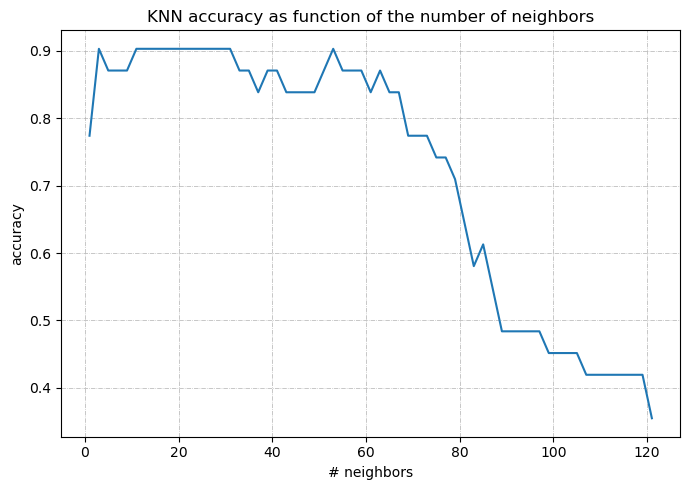

In [ ]:
plt.figure(figsize=(7, 5))
plt.title("KNN accuracy as function of the number of neighbors")
sns.lineplot(x="# neighbors", y="accuracy", data=df_knn_scores_md)
plt.grid(linestyle='-.', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
knn_md = KNeighborsClassifier(n_neighbors=n)
knn_md.fit(X=X_train, y=y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn_cv_scores = cross_val_score(estimator=knn, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV KNN accuracy: {knn_cv_scores.mean():.4f} +/- {knn_cv_scores.std():.4f}")
knn_cv_scores

Mean CV KNN accuracy: nan +/- nan


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Accuracy of k-nn classifier on test set with k=3: 0.903


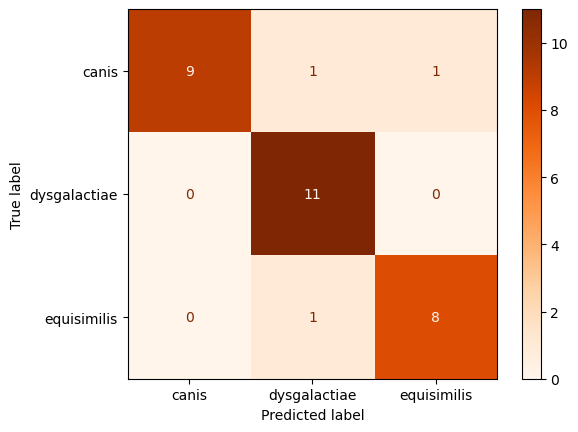

In [ ]:
y_pred = knn_md.predict(X=X_test)
accuracy_knn_md = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of k-nn classifier on test set with k='+str(n)+': {:.3f}'.format(accuracy_knn_md))
ConfusionMatrixDisplay.from_estimator(estimator=knn_md, X=X_test, y=y_test, cmap='Oranges')

In [ ]:
report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

       canis       1.00      0.82      0.90        11
dysgalactiae       0.85      1.00      0.92        11
 equisimilis       0.89      0.89      0.89         9

    accuracy                           0.90        31
   macro avg       0.91      0.90      0.90        31
weighted avg       0.91      0.90      0.90        31



### Random forest classifier

In [ ]:
rm_md = RandomForestClassifier(oob_score=True, n_jobs=N_JOBS, random_state=RANDOM_STATE)
rm_md

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [ ]:
rm_cv_scores = cross_val_score(estimator=rm_md, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV Random Forest accuracy: {rm_cv_scores.mean():.4f} +/- {rm_cv_scores.std():.4f}")
rm_cv_scores

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean CV Random Forest accuracy: 0.8692 +/- 0.0853


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.4s finished


array([0.92307692, 0.84615385, 0.92307692, 0.91666667, 1.        ,
       0.66666667, 0.83333333, 0.83333333, 0.91666667, 0.83333333])

In [ ]:
n_estimator = 25
max_features = 'sqrt'
max_depth = 5
class_weight = 'balanced'
best_rm_md = RandomForestClassifier(n_estimators=n_estimator, max_features=max_features, max_depth=max_depth, class_weight=class_weight, oob_score=True, n_jobs=N_JOBS, random_state=RANDOM_STATE)
best_rm_md.fit(X=X_train, y=y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=25,
                       n_jobs=-1, oob_score=True, random_state=42)

In [ ]:
best_rm_cv_scores = cross_val_score(estimator=best_rm_md, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV Best Random Forest accuracy: {best_rm_cv_scores.mean():.4f} +/- {best_rm_cv_scores.std():.4f}")
best_rm_cv_scores

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean CV Best Random Forest accuracy: 0.8776 +/- 0.0673


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished


array([0.92307692, 0.84615385, 0.92307692, 0.91666667, 1.        ,
       0.75      , 0.83333333, 0.83333333, 0.91666667, 0.83333333])

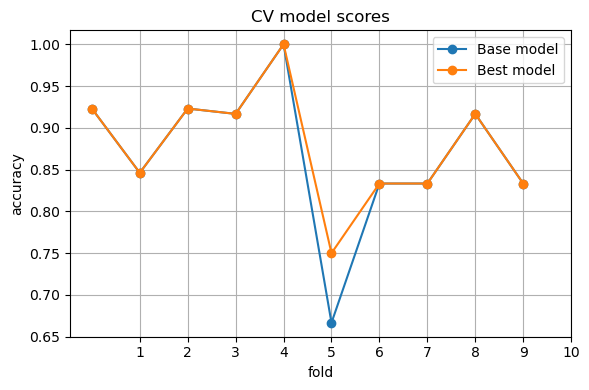

In [ ]:
plt.figure(figsize=(6, 4))
plt.title("CV model scores")
plt.plot(rm_cv_scores, marker="o")
plt.plot(best_rm_cv_scores, marker="o")
plt.xticks(ticks=range(1, 11))
plt.xlabel("fold")
plt.ylabel("accuracy")
plt.legend(["Base model", "Best model"])
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
feature_importances_plot(model=best_rm_md, labels=X.columns)

In [ ]:
best_rm_md.oob_score_

In [ ]:
y_pred = best_rm_md.predict(X_test)

In [ ]:
report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)